In [1]:
!pip install gdown
!gdown --id 1LDStOGuPFQRyl0jug70sNzqyrNJRDBx_
!gdown --id 1X5Ek5mQYjNkw8k87gt_VCFDhPCSwXbmF

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1LDStOGuPFQRyl0jug70sNzqyrNJRDBx_
From (redirected): https://drive.google.com/uc?id=1LDStOGuPFQRyl0jug70sNzqyrNJRDBx_&confirm=t&uuid=b4117b03-b737-4cf0-b9f3-2f50a1561788
To: /kaggle/working/3D-IR-MAH-CT.zip
100%|███████████████████████████████████████| 2.73G/2.73G [00:11<00:00, 237MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1X5Ek5mQYjNkw8k87gt_VCFDhPCSwXbmF
From (redirected): https://drive.google.com/uc?id=1X5Ek5mQYjNkw8k87gt_VCFDhPCSwXbmF&confirm=t&uuid=eee99cab-f883-42a4-a4

In [ ]:
!unzip '/kaggle/working/NL3DTIF.zip' -d '/kaggle/working/'
!unzip '/kaggle/working/3D-IR-MAH-CT.zip' -d '/kaggle/working/'

In [3]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy import ndimage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
print("Num CPU(s) Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPU(s) Available: ", len(tf.config.list_physical_devices('GPU')))

Num CPU(s) Available:  1
Num GPU(s) Available:  1


In [5]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 128
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[0]
    current_width = img.shape[1]
    current_height = img.shape[2]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (depth_factor, width_factor, height_factor, 1))
    return img






def plot_slices(num_rows, num_cols, data):
    # create figure
    fig = plt.figure(figsize=(10, 7))
    
    n = len(data)
  
    for i in range(num_rows * num_cols):
        if i < n:
            # Adds a subplot at the 1st position
            fig.add_subplot(num_rows, num_cols, i+1)

            # showing image
            plt.imshow(data[i])
            plt.axis('off')
            
            
      
    
    
def prepare_3D_samples(main_dir, inp_lst):
    
    final_lst = []
    for i in tqdm(inp_lst):
        tmp_dir = os.path.join(main_dir,i)
        tmp_lst = os.listdir(tmp_dir)
        tmp_lst.sort()
        
        tmp_3d = []
        for j in tmp_lst:
            tmp_3d.append(plt.imread(os.path.join(main_dir,i,j)))
        
        
        final_lst.append(resize_volume(np.array(tmp_3d)))
    
    return np.array(final_lst)




def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 0, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        return volume
    
    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


In [6]:
cov_main_dir = '/kaggle/working/covid_3D'
norm_main_dir = '/kaggle/working/NL3DTIF'

cov_lst = os.listdir(cov_main_dir)
cov_lst.sort()
random.Random(1).shuffle(cov_lst)

norm_lst = os.listdir(norm_main_dir)
norm_lst.sort()
random.Random(1).shuffle(norm_lst)

print(len(cov_lst))
print(cov_lst[:5])
print(len(norm_lst))
print(norm_lst[:5])
print('_________')

covid_volume = prepare_3D_samples(cov_main_dir, cov_lst)
normal_volume = prepare_3D_samples(norm_main_dir, norm_lst)
print('_________')

print('covid_volume:', np.shape(covid_volume))
print('normal_volume:', np.shape(normal_volume))

133
['77', '84', '65', '61', '97']
76
['020', '067', '003', '057', '012']
_________


100%|██████████| 76/76 [35:49<00:00, 28.28s/it]


_________
covid_volume: (133, 128, 128, 128, 3)
normal_volume: (76, 128, 128, 128, 3)


In [7]:
normal_labels = np.array([1 for _ in range(len(normal_volume))])
covid_labels = np.array([0 for _ in range(len(covid_volume))])

In [8]:
x_train = np.concatenate((covid_volume[:107], normal_volume[:61]), axis=0)
y_train = np.concatenate((covid_labels[:107], normal_labels[:61]), axis=0)

x_valid = np.concatenate((covid_volume[107:120], normal_volume[61:68]), axis=0)
y_valid = np.concatenate((covid_labels[107:120], normal_labels[61:68]), axis=0)

x_test = np.concatenate((covid_volume[120:], normal_volume[68:]), axis=0)
y_test = np.concatenate((covid_labels[120:], normal_labels[68:]), axis=0)

In [9]:
print('x_train:', np.shape(x_train))
print('y_train:', np.shape(y_train))
print('x_valid:', np.shape(x_valid))
print('y_valid:', np.shape(y_valid))
print('x_test:', np.shape(x_test))
print('y_test:', np.shape(y_test))

x_train: (168, 128, 128, 128, 3)
y_train: (168,)
x_valid: (20, 128, 128, 128, 3)
y_valid: (20,)
x_test: (21, 128, 128, 128, 3)
y_test: (21,)


label: 0
label 1 is normal and label 0 is covid 19


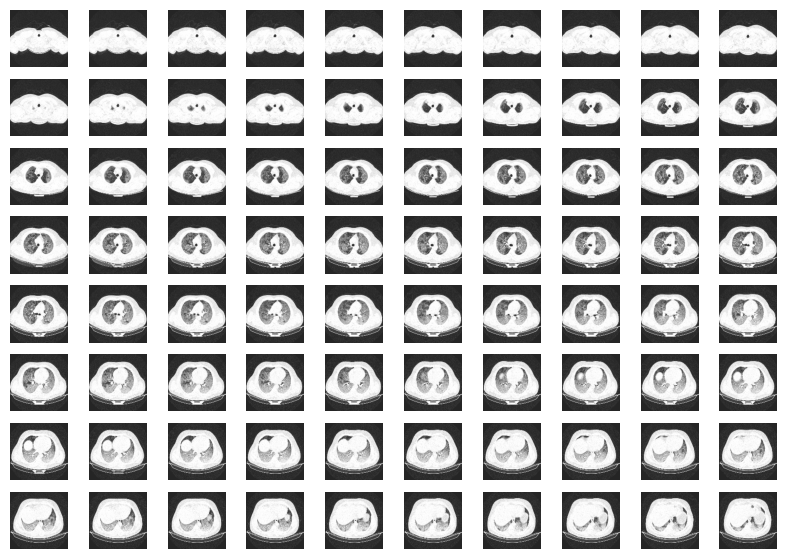

In [12]:
# visualize a sample in x_train

print('label:',y_train[0])
print('label 1 is normal and label 0 is covid 19')

plot_slices(8,10,x_train[0])

In [11]:
def train_preprocessing(volume, label):
    # rescaling
    volume = tf.cast(volume, tf.float32) / 255.0
    # Rotate volume
    volume = rotate(volume)
    return volume, label


def validation_preprocessing(volume, label):
    # rescaling
    volume = tf.cast(volume, tf.float32) / 255.0
    return volume, label

In [19]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 2

# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(1)
)

# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_valid))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(1)
)

# Only rescale.
test_dataset = (
    test_loader.shuffle(len(x_test))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(1)
)

# MASERes Network

In [14]:
from keras.layers import Flatten, Activation, RepeatVector, Permute, Multiply, Lambda, Dense

def SE(inputs, ratio = 8):
    c = np.shape(inputs)[-1]    
    x = tf.keras.layers.GlobalAveragePooling3D()(inputs)   
    x = tf.keras.layers.Dense(c//ratio, activation='relu', use_bias=False)(x)
    x = tf.keras.layers.Dense(c, activation = 'sigmoid', use_bias = False)(x)    
    x = Multiply()([inputs, x])   
    return x

def attBlock(input_tensor):
    k = Dense(1)(input_tensor)
    q = Dense(1)(input_tensor)
    v = Dense(1)(input_tensor)
    alpha = tf.keras.layers.Activation('softmax')(Multiply()([k, q]))
    c = Multiply()([alpha, v])
    return c

def SE_resBlock(input_tensor, n_filters):
    x = tf.keras.layers.BatchNormalization()(input_tensor)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv3D(filters=n_filters , kernel_size=(3,3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv3D(filters=n_filters ,kernel_size=(3,3,3) , padding='same')(x)
    x = SE(x)
    output_tensor = x + tf.keras.layers.Conv3D(filters=n_filters , kernel_size=(1,1,1))(input_tensor)
    model = tf.keras.models.Model(input_tensor, output_tensor)
    return model, output_tensor

def model_arch():
    inp = tf.keras.Input((128,128,128,3))
    x = tf.keras.layers.Conv3D(filters=16 , kernel_size=(3,3,3), padding='same')(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv3D(filters=16 , kernel_size=(3,3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    m, o = SE_resBlock(x, 32)
    m, o = SE_resBlock(o, 32)
    m, o = SE_resBlock(o, 32)
    x = tf.keras.layers.MaxPooling3D((7,7,7))(o)
    x1 = attBlock(x)
    x2 = attBlock(x)
    x3 = attBlock(x)
    x = tf.keras.layers.Concatenate()([x1, x2, x3])
    x = Flatten()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(16, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = Dense(1, activation = 'sigmoid')(x)
    
    return tf.keras.models.Model(inp, x)

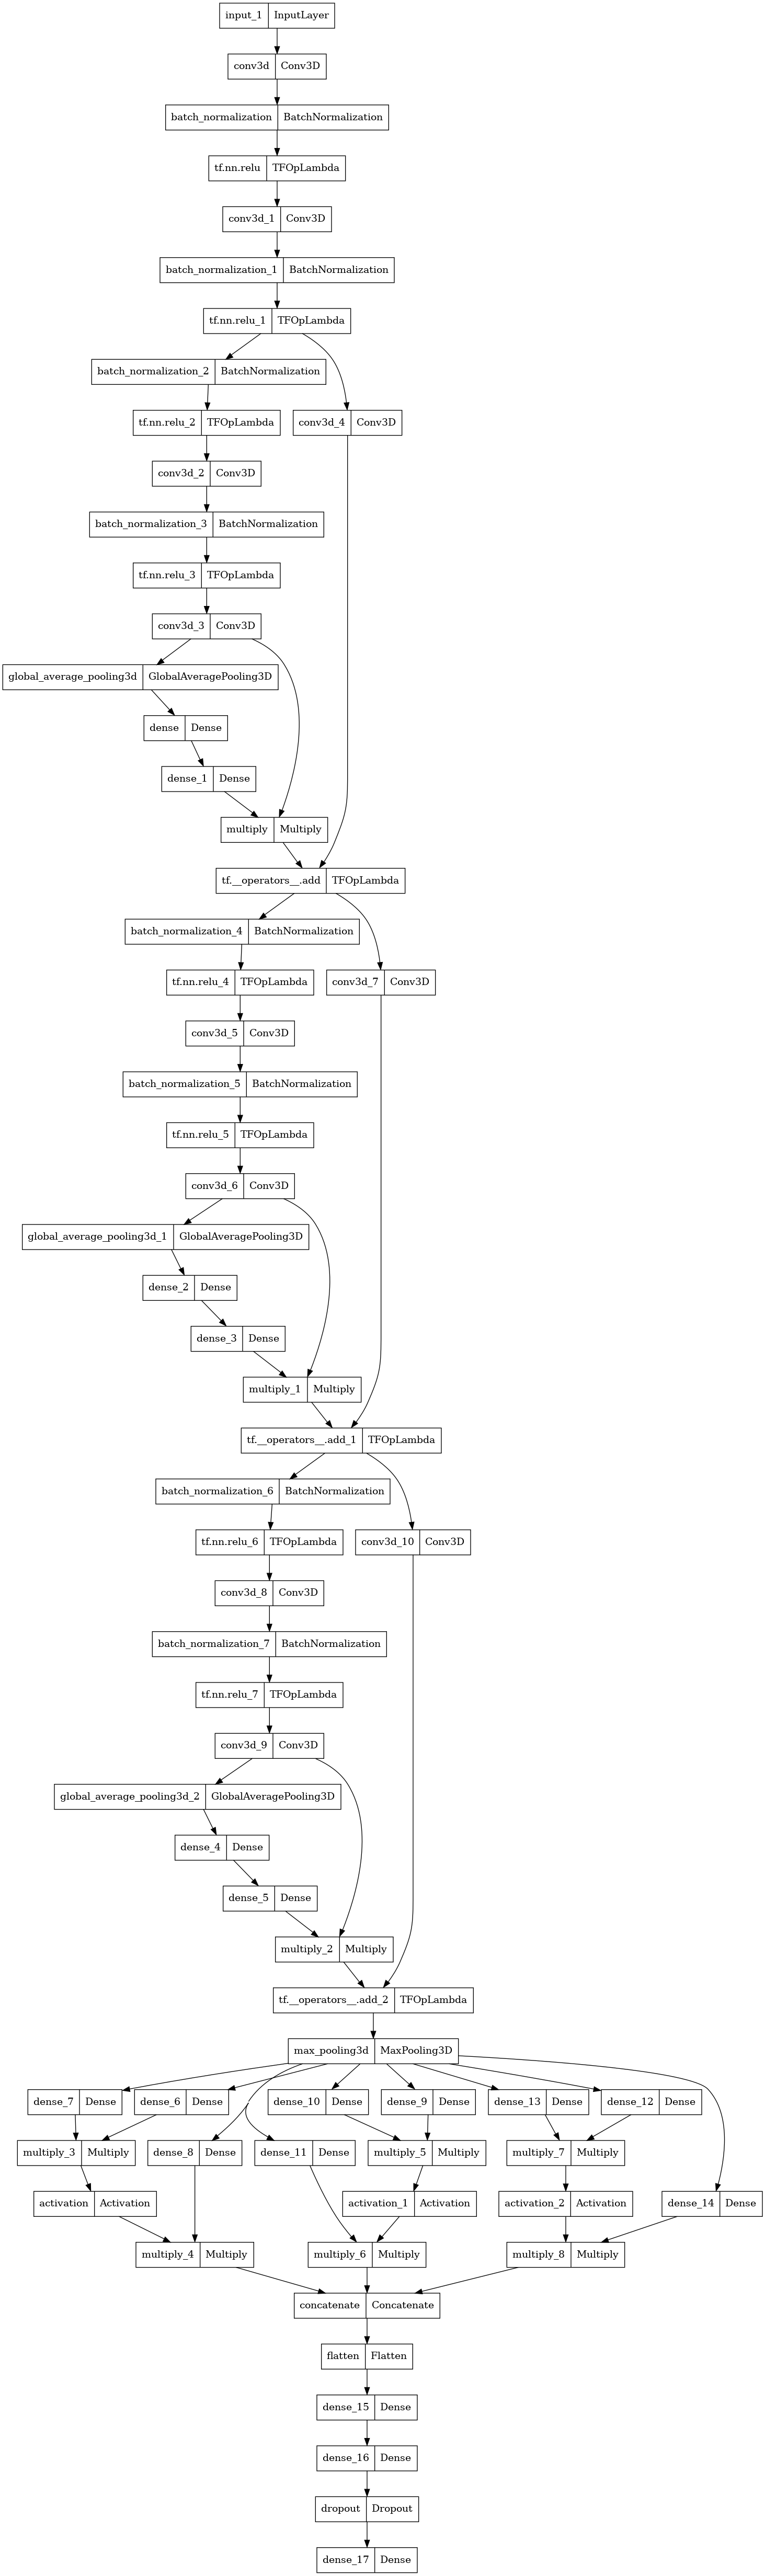

In [15]:
MASERes = model_arch()
tf.keras.utils.plot_model(MASERes)

In [16]:
MASERes.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 12  64         ['conv3d[0][0]']                 
 alization)                     8, 16)                                                      

# Optimum LR

In [47]:
# finding appropreate learning rate

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8 * 10 ** (epoch/20)
)

MASERes.compile(optimizer='adam' , loss='binary_crossentropy')

In [50]:
history = MASERes.fit(train_dataset,
                    validation_data = validation_dataset,
                    callbacks=[lr_schedule],
                    epochs = 100,
                    verbose = 1)

Epoch 1/100
84/84 [==============================] - 234s 3s/step - loss: 1.7686 - val_loss: 0.7027 - lr: 1.0000e-08
Epoch 2/100
84/84 [==============================] - 227s 3s/step - loss: 1.4197 - val_loss: 0.7189 - lr: 1.1220e-08
Epoch 3/100
84/84 [==============================] - 221s 3s/step - loss: 1.7442 - val_loss: 0.7724 - lr: 1.2589e-08
Epoch 4/100
84/84 [==============================] - 220s 3s/step - loss: 1.4985 - val_loss: 0.8614 - lr: 1.4125e-08
Epoch 5/100
84/84 [==============================] - 219s 3s/step - loss: 1.4756 - val_loss: 0.9562 - lr: 1.5849e-08
Epoch 6/100
84/84 [==============================] - 217s 3s/step - loss: 1.5845 - val_loss: 1.0371 - lr: 1.7783e-08
Epoch 7/100
84/84 [==============================] - 219s 3s/step - loss: 1.3681 - val_loss: 1.0954 - lr: 1.9953e-08
Epoch 8/100
84/84 [==============================] - 221s 3s/step - loss: 1.6527 - val_loss: 1.1353 - lr: 2.2387e-08
Epoch 9/100
84/84 [==============================] - 225s 3s/ste

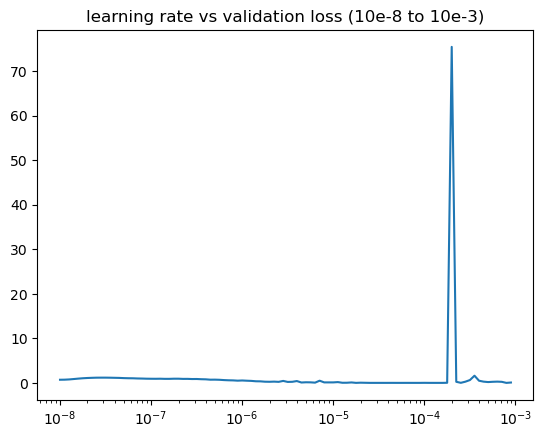

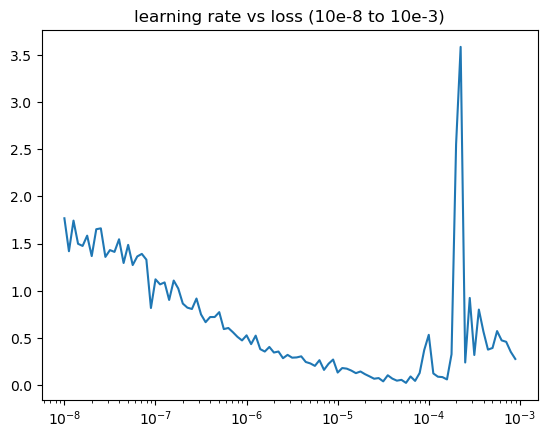

<Figure size 640x480 with 0 Axes>

In [51]:
#plot learning rate schedule

lrs = 1e-8 * (10**(np.arange(100)/20))
plt.semilogx(lrs , history.history['val_loss'])
plt.title('learning rate vs validation loss (10e-8 to 10e-3)')
plt.figure()
plt.semilogx(lrs , history.history['loss'])
plt.title('learning rate vs loss (10e-8 to 10e-3)')
plt.figure()

plt.show()

# Training Process

In [20]:
MASERes = model_arch()
MASERes.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-6),
                   loss='binary_crossentropy', metrics = ['acc'])

In [21]:
history = MASERes.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = 50,
                    verbose = 1)

Epoch 1/50
84/84 [==============================] - 238s 3s/step - loss: 0.9905 - acc: 0.6190 - val_loss: 0.6477 - val_acc: 0.6500
Epoch 2/50
84/84 [==============================] - 221s 3s/step - loss: 0.7553 - acc: 0.6012 - val_loss: 0.6367 - val_acc: 0.6000
Epoch 3/50
84/84 [==============================] - 219s 3s/step - loss: 0.6855 - acc: 0.5893 - val_loss: 0.6283 - val_acc: 0.6500
Epoch 4/50
84/84 [==============================] - 222s 3s/step - loss: 0.6438 - acc: 0.6012 - val_loss: 0.5498 - val_acc: 0.7500
Epoch 5/50
84/84 [==============================] - 222s 3s/step - loss: 0.6123 - acc: 0.6845 - val_loss: 0.4983 - val_acc: 0.8000
Epoch 6/50
84/84 [==============================] - 221s 3s/step - loss: 0.6081 - acc: 0.6726 - val_loss: 0.4896 - val_acc: 0.8500
Epoch 7/50
84/84 [==============================] - 222s 3s/step - loss: 0.5262 - acc: 0.7440 - val_loss: 0.4216 - val_acc: 0.8500
Epoch 8/50
84/84 [==============================] - 221s 3s/step - loss: 0.5615 - a

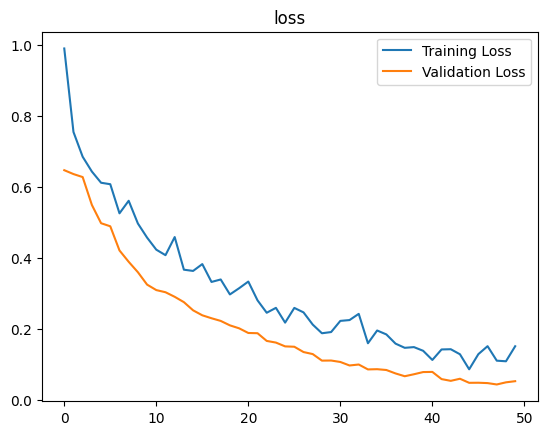

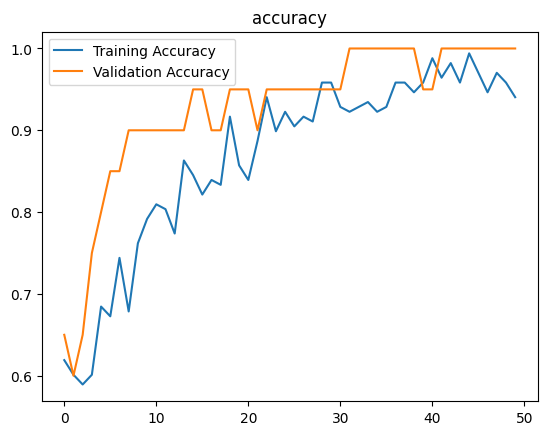

In [22]:
#plot acc and loss

MASERes.save('/kaggle/working/MASERes.h5')

epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['loss'], label='Training Loss')
plt.plot(epochs , history.history['val_loss'], label='Validation Loss')
plt.title('loss')
plt.legend()

plt.figure()

plt.plot(epochs , history.history['acc'], label='Training Accuracy')
plt.plot(epochs , history.history['val_acc'], label='Validation Accuracy')
plt.title('accuracy')
plt.legend()

plt.show()

# Statistics

In [24]:
MASERes.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6) , 
                loss='binary_crossentropy', metrics = ['acc',
                                                      tf.keras.metrics.AUC(),
                                                      tf.keras.metrics.Precision(),
                                                      tf.keras.metrics.Recall(),
                                                      tf.keras.metrics.TruePositives(),
                                                      tf.keras.metrics.TrueNegatives(),
                                                      tf.keras.metrics.FalsePositives(),
                                                      tf.keras.metrics.FalseNegatives()])

In [25]:
a = MASERes.evaluate(test_dataset)

11/11 [==============================] - 6s 394ms/step - loss: 0.0558 - acc: 1.0000 - auc_1: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - true_positives_1: 8.0000 - true_negatives_1: 13.0000 - false_positives_1: 0.0000e+00 - false_negatives_1: 0.0000e+00


In [26]:
conf_mx = [[a[6], a[7]],[a[8], a[5]]]
mx = np.array(conf_mx)
fscore = 2*a[3]*a[4]/(a[3]+a[4])
spc = mx[0, 0] * 1.0 / (mx[0, 0] + mx[0, 1])
sen = mx[1,1] * 1.0 / (mx[1,1] + mx[1,0])

print('accuracy:',np.round(a[1]*100,2),'%')
print('precision:',np.round(a[3]*100,2),'%')
print('recall:',np.round(a[4]*100,2),'%')
print('Sensitivity:',np.round(sen*100,2),'%')
print('Specificity:',np.round(spc*100,2),'%')
print('f1-score:',np.round(fscore*100,2),'%')
print('AUC:',np.round(a[2]*100,2),'%')

accuracy: 100.0 %
precision: 100.0 %
recall: 100.0 %
Sensitivity: 100.0 %
Specificity: 100.0 %
f1-score: 100.0 %
AUC: 100.0 %


In [27]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/MASERes.h5')

/kaggle/working/MASERes.h5